# Final Report

**Group:** 26

**Group members:** 

- Sam Thorne 83910448
- Oliver Gullery 95292827
- Riddhi Battu 85855856
- Kourosh Shahbazi 87286076


To run this notebook `tidyverse`, `glmnet`, `tidymodels`, `mltools`, `IRdisplay` & `reshape2` must be installed. 

In [5]:
# loading necessary libraries:
library(tidyverse)
library(glmnet)
library(tidymodels)
library(mltools)
library(reshape2)
library(IRdisplay)

## New York City Airbnb Data

Data was originally retrieved from [Kaggle](https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data). Raw data can be found on [GitHub](https://raw.githubusercontent.com/samnthorne/FinalProject/main/data/AB_NYC_2019.csv). 

This dataset is a summary of Airbnb information in the New York City area during 2019. The data includes review information, host metrics, general metrics about the Bnb, and booking information. This is a public dataset that can be found on [insideairbnb.com](http://insideairbnb.com/).

### Importance of Analysis:

This dataset is a valuable resource for various stakeholders interested in the dynamics of the sharing economy, particularly in urban settings. There are currently over 4 million hosts and 6 million active listings on [Airbnb](https://www.searchlogistics.com/learn/statistics/airbnb-statistics/#:~:text=There%20are%20currently%20over%204,booked%20over%201%20billion%20stays) [1]. Analysts and researchers can use this data to perform comprehensive market analyses, understand customer and host behavior, and predict trends in the hospitality and tourism industry in New York City.

### Descriptive Summary:

**New York City Airbnb Dataset** has 16 attributes describing various Airbnbs throughout the New York City area in 2019. There are 48895 different Airbnb's presented in this data set. 

### Data Attribute Summary:

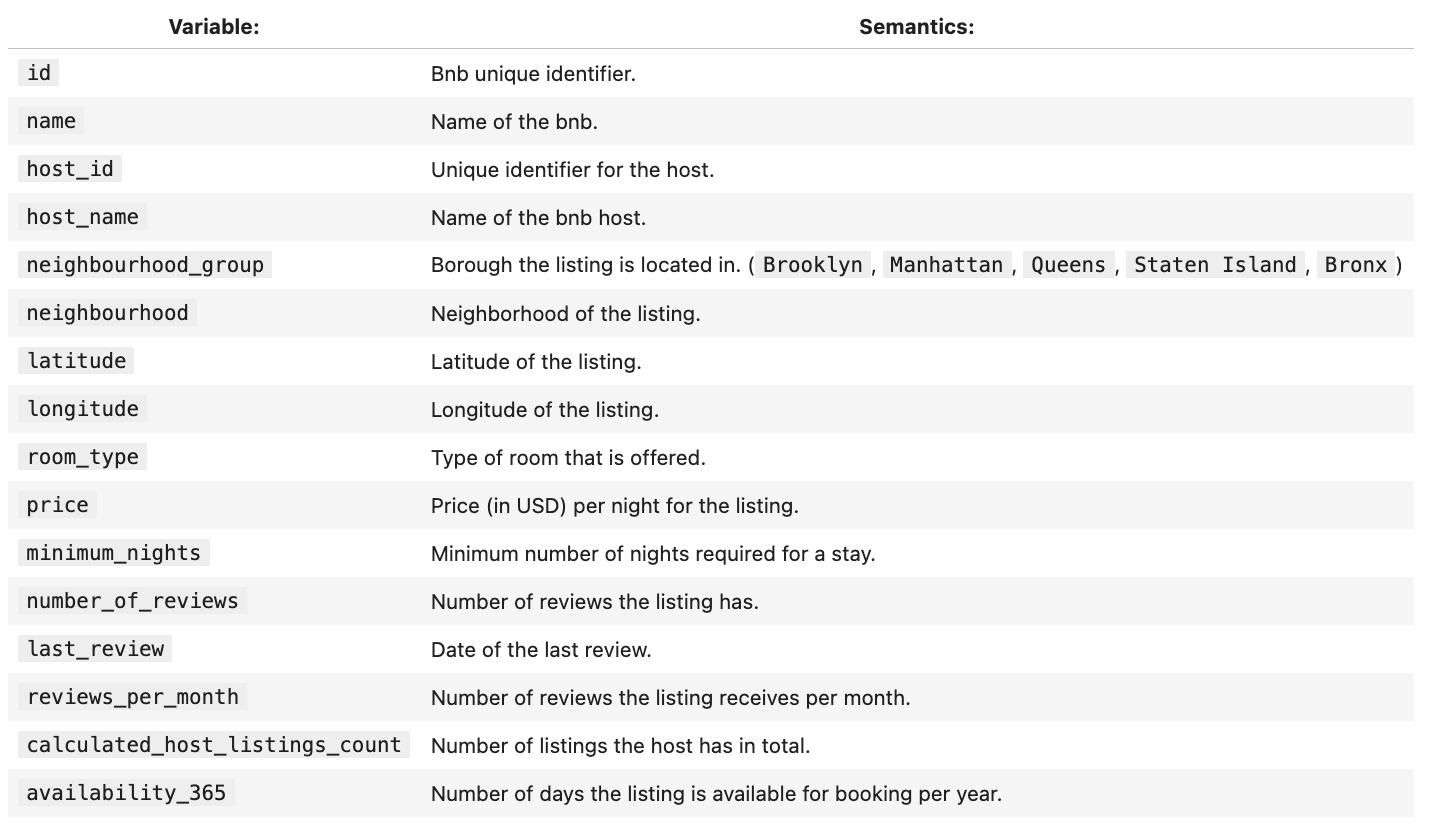

In [12]:
display_png(file="data_attribute_table.png", width=1000, height=600)

<span style = "color :gray;"> **Table 1:** Data attribute summary</span>

### ***Question of interest:***
> *Using the location, availability, room type, & host information, how much should a single night stay at the Airbnb cost?*

This question targets new Airbnb hosts seeking to price their bnb. The aim is to create a predictive model for nightly rates using the variables listed above.

## Reading the data in using R:

The data set is being read in from [GitHub](https://raw.githubusercontent.com/samnthorne/FinalProject/main/data/AB_NYC_2019.csv) despite originally being found on [Kaggle](https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data).

In [1]:
# Removing warning messages from notebook:
options(warn=-1)

# Reading in the data
data_og <- read_csv('https://raw.githubusercontent.com/samnthorne/FinalProject/main/data/AB_NYC_2019.csv')
head(data)

ERROR: Error in read_csv("https://raw.githubusercontent.com/samnthorne/FinalProject/main/data/AB_NYC_2019.csv"): could not find function "read_csv"


<span style = "color: gray;"> **Table 2:** First few rows of New York City AirBnb Data</span>

**Data dimensions:**

In [13]:
print(paste("The data set has dimensions of",dim(data)[1], "by", dim(data)[2]))

[1] "The data set has dimensions of  by "


## Data Cleaning

This data set is quite clean to begin with. Data cleaning will focus on condensing data for analysis use. Many of the `chr` variables will also be re-labelled as `fct` variables.

### Dropping attributes:

As discussed in Assignment1, we are going to be dropping columns `id`, `host_id` `name`, `host_name`, `neighbourhood`, `number_of_reviews`, `last_review`, and `reviews_per_month`. 
- The `name`, `host_name`, `id`, and `host_id` column have completely unique values. These attributes should not alter the ability to predict an appropriate AirBnb price due to all the values in these columns being arbitrary.
- The column `neighbourhood` shares semantic meaning with the column `neighbourhood_group`. To avoid multi-collinearity `neighbourhood` will be dropped as it has more levels than `neighbourhood_group`.
    - *There is a chance that `latitude` and `longitude` will play a role in location multi-collinearity but this will be evaluated via LASSO cross-validation for attribute selection*
- The columns `number_of_reviews`, `last_review`, and `reviews_per_month` all have to do with reviews each bnb has recieved. People have a tendency to leave reviews when they need to vent or if they are giving praise after a positive experience. These two extremes are represented in the same way when only looking at review numbers. To avoid these columns nullifying the models predictions they are all going to be dropped.

In [14]:
# dropping columns we are not using:

data <- data_og %>%
    select(-name, -host_name, -id, -host_id, -neighbourhood, -number_of_reviews, -last_review, -reviews_per_month)
head(data)

ERROR: Error in select(., -name, -host_name, -id, -host_id, -neighbourhood, -number_of_reviews, : object 'data_og' not found


<span style = "color: gray;"> **Table 3:** First 5 rows of shrunken New York City AirBnb data</span>

### Removing Na values:

Checking if there are any other any remaining columns with NA values:

In [50]:
# find NA values and drop those columns?

NA_values <- tibble(Attribute = c("Longitude", "Latitude", "Neighbourhood group", "Room type", 
                                  "Price", "Minimum nights", "Number of host listings", "Availability"),
                    NAs = c(sum(is.na(data$longitude)), sum(is.na(data$latitude)), 
                            sum(is.na(data$neighbourhood_group)), sum(is.na(data$room_type)), 
                            sum(is.na(data$price)), sum(is.na(data$minimum_nights)), 
                            sum(is.na(data$calculated_host_listings_count)), 
                            sum(is.na(data$availability_365)))
                    )
NA_values

Attribute,NAs
<chr>,<int>
Longitude,0
Latitude,0
Neighbourhood group,0
Room type,0
Price,0
Minimum nights,0
Number of host listings,0
Availability,0


<span style = "color: gray;"> **Table 4:** Number of NA values remaining in the condensed New York City Airbnb data</span>

### Changing `chr` to `fct`:

For some of the categorical variables in this data set (`neighbourhood_group`, `room_type`) there are several distinct categories represented in the column. These variables have a fixed, known set of possibilities that are always going to be the same. 

In [51]:
data$neighbourhood_group <- as.factor(data$neighbourhood_group)
data$room_type <- as.factor(data$room_type)

## Exploratory Data Analysis:

Completing exploratory analysis to determine which attributes should be further visualized.

### Attribute Summary:

In [52]:
summary(data)

    neighbourhood_group    latitude       longitude     
 Bronx        : 1091    Min.   :40.50   Min.   :-74.24  
 Brooklyn     :20104    1st Qu.:40.69   1st Qu.:-73.98  
 Manhattan    :21661    Median :40.72   Median :-73.96  
 Queens       : 5666    Mean   :40.73   Mean   :-73.95  
 Staten Island:  373    3rd Qu.:40.76   3rd Qu.:-73.94  
                        Max.   :40.91   Max.   :-73.71  
           room_type         price         minimum_nights   
 Entire home/apt:25409   Min.   :    0.0   Min.   :   1.00  
 Private room   :22326   1st Qu.:   69.0   1st Qu.:   1.00  
 Shared room    : 1160   Median :  106.0   Median :   3.00  
                         Mean   :  152.7   Mean   :   7.03  
                         3rd Qu.:  175.0   3rd Qu.:   5.00  
                         Max.   :10000.0   Max.   :1250.00  
 calculated_host_listings_count availability_365
 Min.   :  1.000                Min.   :  0.0   
 1st Qu.:  1.000                1st Qu.:  0.0   
 Median :  1.000           

A couple points to note about the above summary:
- The categorical level `Staten Island` in the column `neighbourhood_group` has much fewer instances than the other levels seen in this column.
- The categorical level `Shared room` in the column `room_type` also has fewer 

## Correlation Matrix with Numerical Variables

We can create a correlation matrix (`Figure 1`) with the numerical variables in our full dataset which are stated in our `numeric_data` dataframe. This matrix will allow us to identify potential linear correlations between price and other numerical variables. Variables with strong correlation with price could serve as valuable predictors in our regression model.

# A tibble: 8 × 2
  variable                       correlation_with_price
  <chr>                                           <dbl>
1 longitude                                     -0.155 
2 number_of_reviews                             -0.0359
3 reviews_per_month                             -0.0306
4 minimum_nights                                 0.0255
5 latitude                                       0.0313
6 calculated_host_listings_count                 0.0529
7 availability_365                               0.0782
8 price                                          1     


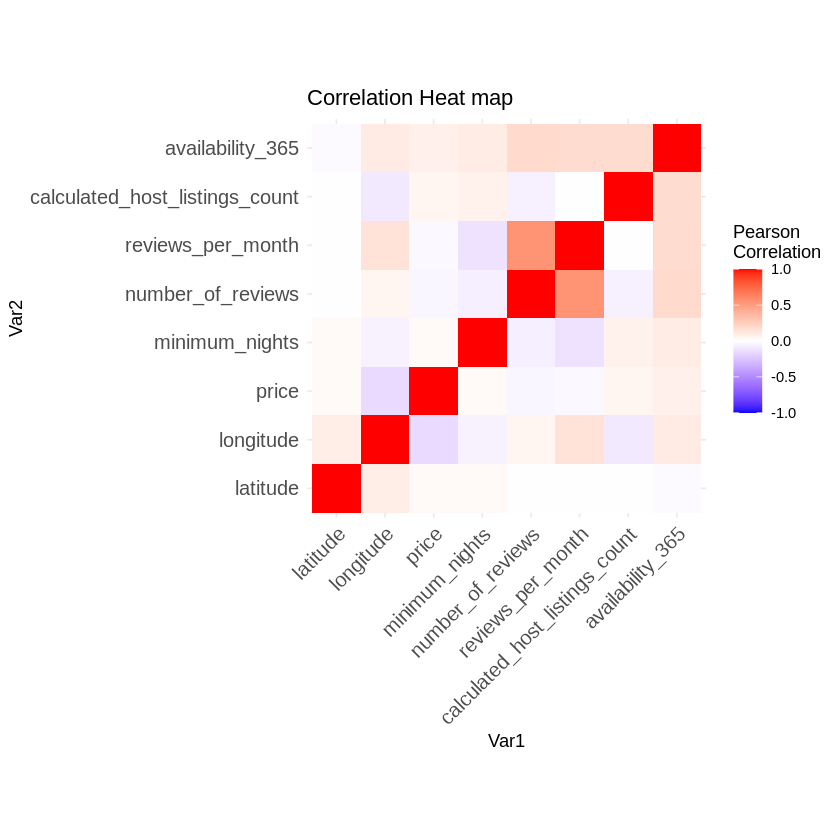

In [24]:
numerical_data <- data_og %>%
  select(latitude, longitude, price, minimum_nights, number_of_reviews, 
         reviews_per_month, calculated_host_listings_count, availability_365)


cor_matrix <- cor(numerical_data, use = "complete.obs") 


melted_cor_matrix <- melt(cor_matrix)

# Create the heatmap
correlation_heat_map <- ggplot(melted_cor_matrix, aes(Var1, Var2, fill = value)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
                       midpoint = 0, limit = c(-1,1), space = "Lab", 
                       name="Pearson\nCorrelation") +
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 12, hjust = 1),
        axis.text.y = element_text(size = 12)) +
  coord_fixed() + ggtitle("Correlation Heat map") # for square cells


price_correlations <- cor_matrix[,"price"]
price_correlations_df <- as.data.frame(price_correlations)


tidy_price_correlations <- tibble(
  variable = rownames(price_correlations_df),
  correlation_with_price = price_correlations
)


ordered_price_correlations <- tidy_price_correlations %>%
  arrange(correlation_with_price)


print(ordered_price_correlations)
correlation_heat_map

<span style = "color : gray;"> **Figure 1**: Correlation metrix of values</span>

**Observations of Figure 1:** 

The correlation matrix revealed that none of the numerical variables had a substantial correlation with price. This indicates that these variables may not serve as reliable linear predictors of price. However, we should note that these features could still be useful with alternative analytical methods which might uncover more complex relationships not captured by linear models. 

## Boxplot with categorical variables:

The goal of this analysis is to determine which variables are most influential when setting a price for a nights stay at an Airbnb. The below visualization explores the relationships between price of a single nights stay and `room_type`, with `neighbourhood_group`. 

From this visualization one can find the mean and quantile ranges of price for each `room_type` - `neighbourhood_group` combination of Airbnbs. 

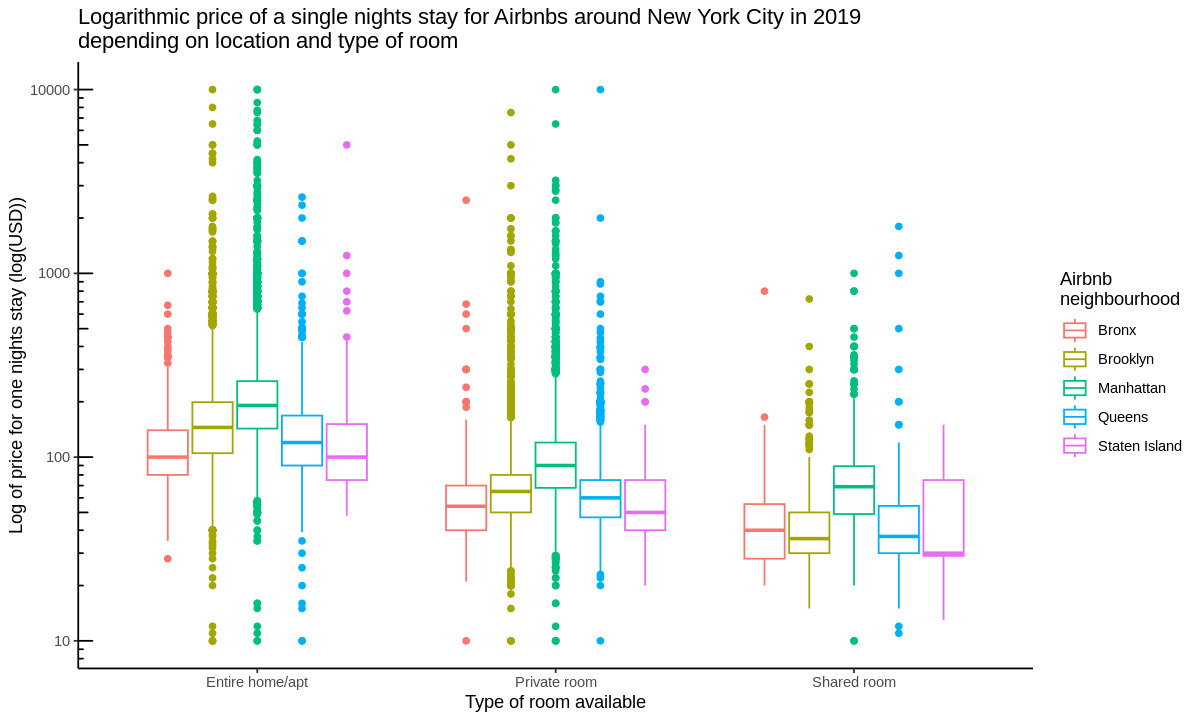

In [27]:
options(repr.plot.width = 10, repr.plot.height = 6)

visualization <- data %>%
    ggplot(aes(color = neighbourhood_group, 
               y = price, 
               x = room_type))+
    geom_boxplot() +
    scale_y_log10() + # to better see the variation in data at lower numbers. 
    annotation_logticks(10, sides = "l", colour = 'black', scaled = TRUE) +
    ggtitle("Logarithmic price of a single nights stay for Airbnbs around New York City in 2019 \ndepending on location and type of room") +
    labs(y = "Log of price for one nights stay (log(USD))",
         x = "Type of room available") +
    scale_color_discrete(name = "Airbnb \nneighbourhood") +
    theme_classic()

visualization
# ggsave('images/Assignment2-Vis.png', plot = visualization)

<span style = "color: gray;">**Figure 2:** Distribution of log(price) based on room type and neighbourhood from New York City Airbnb data. </span>

***Justification for logarithmic scale:***

We chose to display the visualization with a logarithmic scale on the y-axis because the price range goes up very high (`max =  10,000`) while the majority of the points were quite a bit lower (`mean =152.7`). Using a logarithmic scale on the y-axis enables the viewer to analyze the relationships between the variables at lower price points that could be too condensed together to see on an unscaled visualization.

**Observations of Figure 2:**

The relationship between `room_type` and `price` reveals that generally, the price of `Entire home/apt` > `Private room` > `Shared room`. It can also be observed that `Entire home/apt` has the greatest variability in price.

The relationship between neighbourhoods and Airbnb price revealed that the average cost to stay in an Airbnb in Manhattan is higher than any other neighbourhood no matter the type of room and the least costly neighbourhood is `Staten Island`.

Overall, there are some clear trends between `room_type` and `neighbourhood_group` with `price`. This visualization confirms that these attributes will likely help to predict appropriate Airbnb pricing. Additionally, it provides insight about how the pricing of an Airbnb should change with either room type or neighbourhood.

## Methods and Plan

The objective is to predict appropriate Airbnb prices for new listings using both categorical and numerical variables. 

### Proposed Method:

The data will be split, followed by cross-validation with LASSO for variable selection. The selected variables will be used in a least squares multi-linear regression. The model's effectiveness will be assessed on test data to find RMSE.

LASSO will assist in identifying the most effective variables. `Latitude` and `longitude` will be reintroduced to describe the location quantitatively, in contrast to the categorical `neighbourhood_group`. This approach facilitates linear regression interpretability, reducing the need for multiple dummy variables for categorical levels.

The model aims to accurately predict Airbnb pricing. RMSE, indicating prediction deviation from actual values, will be used post-training for performance evaluation.

### Assumptions:

Multi-linear regression assumes [2]:
1. Linear relationships.
2. Independent errors.
3. Normally distributed error terms.
4. Homoscedasticity (equal error variance).
5. Minimal multi-collinearity.

### Potential Limitations:

Linear regression complexity increases with multiple categorical levels. To mitigate this, categorical variables will be simplified (e.g., `room_type` into `shared` and `private`). 

A concern is the potential multicollinearity, especially when including both `latitude`, `longitude`, and `neighbourhood_group`. LASSO might randomly select among correlated variables, possibly excluding optimal predictors.

## Implementation of proposed model

### Minor Data Wrangling Pre-Implementation

Based on a New York City Area map and our prior visualization, the `neighbourhood_group` values will be reassigned into `East` and `West`. Here, `Staten Island` and `Manhattan` will be categorized as `West`, with the other communities falling under `East`. `room_type` is being re-categorized as suggested in the limitations above.

In [31]:
model_data <- data

# Re-grouping neighbourhood_group to be binomial
model_data$neighbourhood_group <- str_replace(model_data$neighbourhood_group, 'Brooklyn', 'East')
model_data$neighbourhood_group <- str_replace(model_data$neighbourhood_group, 'Staten Island', 'West')
model_data$neighbourhood_group <- str_replace(model_data$neighbourhood_group, 'Manhattan', 'West')
model_data$neighbourhood_group <- str_replace(model_data$neighbourhood_group, 'Bronx', 'East')
model_data$neighbourhood_group <- str_replace(model_data$neighbourhood_group, 'Queens', 'East')

# Re-grouping room_type
model_data$room_type <- str_replace(model_data$room_type, 'Shared room', 'Shared')
model_data$room_type <- str_replace(model_data$room_type, 'Private room', 'Private')
model_data$room_type <- str_replace(model_data$room_type, 'Entire home/apt', 'Private')

#### Splitting the data:

In [32]:
# Splitting the data
data_split <- initial_split(model_data, prop = 0.7, strata = price)
data_train <- training(data_split)
data_test <- testing(data_split)

#### Attribute selection via cross-validation with LASSO

In [33]:
# Finding optimal lambda value:
bnb_model <- cv.glmnet(data_train %>%
                       select(-price) %>%
                       as.matrix(),
                       y = data_train$price,
                       alpha = 1)
# bnb_model

In [43]:
# Found that min lambda produces a smaller Mean-Squared Error.
# Going to be using min lambda from the model built above.

# Extracting used coefficients from the model above.
attributes <- coef(bnb_model,
                   s = bnb_model$lambda.min)

# Uncomment to see the s1 values for the variables and what variables were selected.
# attributes

selected <- as_tibble(
    as.matrix(attributes),
    rownames = 'Attributes') %>%
    filter(Attributes != '(Intercept)' & abs(s1) != 0)

# Uncomment to see tibble containing s1 values of selected attributes.
# selected


# tidy(bnb_model)



#### Building Least Squares Model:

In [44]:
ls_model <- lm(paste("price~", paste(selected %>% pull(Attributes), collapse = " + ")),
               data = data_train)

tidy(ls_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-6.963343e+04,2.529855e+03,-27.524675,5.606930e-165
latitude,2.252291e+02,2.503408e+01,8.996898,2.438383e-19
longitude,-8.193589e+02,3.002745e+01,-27.286994,3.315660e-162
minimum_nights,2.003719e-01,6.494428e-02,3.085290,2.035163e-03
calculated_host_listings_count,1.253572e-01,4.322826e-02,2.899889,3.735325e-03
availability_365,1.573914e-01,1.067097e-02,14.749493,4.387786e-49


<span style = "color: gray;"> **Table 5:** Simple linear regression model using attributes selected from LASSO.</span>

#### Predictions and Calculating RMSE:

In [45]:
predictions <- predict(ls_model, data_test)

rmse_val <- sqrt(mean((data_test$price - predictions)^2))
rmse_val

[1] 198.1308

In [46]:
# printing range of price to get an idea of the scale for RMSE interpretation
summary(data_test$price)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0    69.0   106.0   150.8   175.0  9999.0 

### Interpretations of Results:

The RMSE is suggesting there is a error of ~ 240 for each prediction on the test data, this is quite large given the mean of this attribute is 151. The response variable `price` has a large range from 10000 to 0, it is likely that these extreme values are influencing the resulting RMSE.

A peculiar result can also been seen in Table 5 when analyzing p-values; particularly the p-value for the attribute `longitude` suggests this attribute is *very* significant when predicting `price` which is odd considering `latitude` is not nearly as significant. We would be interested in what kind of model would be produced if these variables were removed, would `neighbourhood_group` become significant with this multi-collinearity issue resolved?

### Discussion of Our Results

In this project, we aimed to predict the price of accommodations in New York City using various attributes. Throughout the process, we have gained valuable insights and identified areas for improvement.

#### Summary of Our Findings
- **Model Implementation**: We successfully implemented a linear regression model using attributes selected via LASSO regression. This approach was instrumental in identifying the most relevant predictors while addressing the issue of multicollinearity.
- **Key Predictors**: Our analysis highlighted longitude and latitude as significant predictors of price. Interestingly, longitude had a more substantial impact than expected, underscoring the geographical component in accommodation pricing.
- **Model Performance**: The Root Mean Squared Error (RMSE) of our model was approximately 198.13. This error margin, in the context of the dataset's price range, indicates a notable discrepancy between predicted and actual prices, suggesting a need for refining our model.

#### Reflection on Expectations
- The prominence of longitude in predicting price was a surprising outcome. We initially hypothesized that both geographical coordinates would have similar levels of influence on pricing.
- The reclassification of `neighbourhood_group` into `East` and `West` was a strategic decision based on our understanding of New York City's geography. The significance of these variables in our model was in line with our expectations.

#### Limitations of Our Model and Potential Improvements
- **Risk of Overfitting**: The RMSE suggests that our model might be too closely fitted to the training data. We could explore additional regularization techniques to address this.
- **Feature Engineering**: While our approach to re-categorize `neighbourhood_group` was a crucial step, further refinement in categorization or the introduction of new features might enhance the model’s predictive power.
- **Exploring Non-Linearity**: Our current model is based on the assumption of a linear relationship between predictors and price. Given the complex nature of real-world data, incorporating non-linear models or transformations could be more effective.

#### Future Research Directions
- Investigating models that can capture non-linear relationships, such as polynomial regression or tree-based methods, would be a valuable next step.
- Incorporating time-based features could provide a more nuanced understanding of pricing dynamics, as accommodation prices can vary significantly over time.
- Integrating external datasets, such as economic indicators or tourism statistics, might enrich our analysis and offer a more comprehensive view of the factors influencing accommodation prices.

#### Overall Impact of Our Study
Our study provides essential insights into the factors influencing accommodation pricing in New York City, with a particular emphasis on geographical elements. These findings are valuable for stakeholders in the real estate and hospitality sectors for developing informed pricing strategies. Our research also lays the groundwork for future studies to explore more complex models and integrate a broader range of data, furthering our understanding of urban accommodation pricing.


## References:

[1] Search Logistics Airbnb [(source_1)](https://www.searchlogistics.com/learn/statistics/airbnb-statistics/#:~:text=There%20are%20currently%20over%204,booked%20over%201%20billion%20stays).

[2] Introduction to Statistical Learning with Applications in R ([Source_2](https://www.amazon.ca/Introduction-Statistical-Learning-Applications/dp/1071614177/ref=asc_df_1071614177/?tag=googleshopc0c-20&linkCode=df0&hvadid=459879753056&hvpos=&hvnetw=g&hvrand=385946665552058214&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=9001553&hvtargid=pla-1147835592944&psc=1&mcid=3e5ad03efcdf31559e2b27c21942fb0b]))